# Cell-type Identification of PBMC Dataset

Here, we analyze the peripheral blood mononuclear cell (PBMC) dataset from 10X Genomics. 

The goal of this analysis is to walk through a **basic analytical pipeline for cell type recognition in droplet-based scRNA-seq data**. Droplet-based sequencing technologies are a popular method for single-cell RNA sequencing due to their relatively high throughput and low sequencing costs. 10X Genomics' droplet-based system (Zheng et al., 2017) is a scalable and robust technology, capable of sequencing tens of thousands of cells in parallel. Here, we analyze the peripheral blood mononuclear cell (PBMC) dataset from 10X Genomics. 

Peripheral blood mononuclear cells (PBMCs) are blood cells that are a critical part of the immune system which primarily fight off infection. However, PBMCs consist of multiple cell types and studying the function of the different cell types can be difficult using bulk RNA sequencing methods. As such, single-cell RNA sequencing is a valuable tool for studying the heterogeneity and differential expression of PMBCs. 

In [1]:
# BiocFileCache is a package which allows easy access to many public datasets, including this 10X Genomics PBMC data
suppressMessages(library(BiocFileCache))
# DropletUtils is a package for handling scRNA-seq droplet data
suppressMessages(library(DropletUtils))
# scater is a package for the pre-processing, quality control, normalization, and visualization of sc-RNAseq data
suppressMessages(library(scater))
# EnsDb.Hsapiens.v86 is a package for gene annotation, particularly human genes
suppressMessages(library(EnsDb.Hsapiens.v86)) 
# scran is a general package for scRNA-seq analysis including normalization and gene detection, among others
suppressMessages(library(scran))
# SingleR is a package which utilizes reference transcriptomic datasets of pure cell types to identify cell types
suppressMessages(library(SingleR))
# package for constructing heatmaps
suppressMessages(library(pheatmap))

# Loading the data

In [2]:
# this code accesses the dataset from the 10X Genomics website
bfc <- BiocFileCache("raw_data", ask = FALSE)
raw.path <- bfcrpath(bfc, file.path("http://cf.10xgenomics.com/samples",
    "cell-exp/2.1.0/pbmc4k/pbmc4k_raw_gene_bc_matrices.tar.gz"))
untar(raw.path, exdir=file.path(tempdir(), "pbmc4k"))
fname <- file.path(tempdir(), "pbmc4k/raw_gene_bc_matrices/GRCh38")

In [3]:
sce.pbmc <- read10xCounts(fname, col.names=TRUE) 

The *read10xCounts( )* function loads data from a 10X Genomics experiment into a SingleCellExperiment object, for use in the R-based Bioconductor ecosystem

In [4]:
sce.pbmc

class: SingleCellExperiment 
dim: 33694 737280 
metadata(1): Samples
assays(1): counts
rownames(33694): ENSG00000243485 ENSG00000237613 ... ENSG00000277475
  ENSG00000268674
rowData names(2): ID Symbol
colnames(737280): AAACCTGAGAAACCAT-1 AAACCTGAGAAACCGC-1 ...
  TTTGTCATCTTTAGTC-1 TTTGTCATCTTTCCTC-1
colData names(2): Sample Barcode
reducedDimNames(0):
altExpNames(0):

As you can see from the dimensions of this SingleCellExperiment, there are some 34,000 genes and 737,000 cells in this dataset.

In [5]:
# the following code sets unique gene IDs as row names and assigns functional annotations to the genes
rownames(sce.pbmc) <- uniquifyFeatureNames( 
    rowData(sce.pbmc)$ID, rowData(sce.pbmc)$Symbol)

suppressWarnings(location <- mapIds(EnsDb.Hsapiens.v86, keys=rowData(sce.pbmc)$ID,
                    column="SEQNAME", keytype="GENEID"))

# Quality Control

Low quality scRNA-seq data can be introduced from many sources including cell damage during dissociation or inefficient library preparation. These problematic libraries tend to have low total counts, few expressed genes, and high mitochondrial/spike-in proportions. As such, it is important to identify and remove low quality data so that downstream analyses are not effected.

Droplet-based scRNA-seq data poses a unique problem for QC. There is no prior way to know whether a particular library corresponds to a cell or an empty droplet
- The *emptyDrops( )* function to tests whether the expression profile for each cell is significantly different from the ambient RNA pool

In [6]:
set.seed(100)
# test whether each cells expression profile is significantly different from ambient RNA expression profile
e.out <- emptyDrops(counts(sce.pbmc))

# the following line subsets the SingleCellExperiment object to retain only detected cells. FDR = false detection rate
sce.pbmc <- sce.pbmc[,which(e.out$FDR <= 0.001)]

In [7]:
# a SingleCellExperiment copy
unfiltered <- sce.pbmc

In [8]:
# apply QC metrics to the subset of data with mitochondrial transcripts
stats <- perCellQCMetrics(sce.pbmc, subsets=list(Mito=which(location=="MT")))
# identify cells that have outlier proportions of mitochondrial transcripts
high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
# subsets the SingleCellExperiment to everything with NOT high mito proportions
sce.pbmc <- sce.pbmc[,!high.mito] 
#add stats info to the SingleCellExpriment copy and then removes cells with high mito proportions
colData(unfiltered) <- cbind(colData(unfiltered), stats)
unfiltered$discard <- high.mito

- The *perCellQCMetrics( )* function calculates various QC metrics, including the percentage of reads mapped to mitochondrial transcripts.
- The *isOutlier( )* function identifies cells that are outliers based on the median absolute deiviation (MAD) from the median value of each metric across cells.

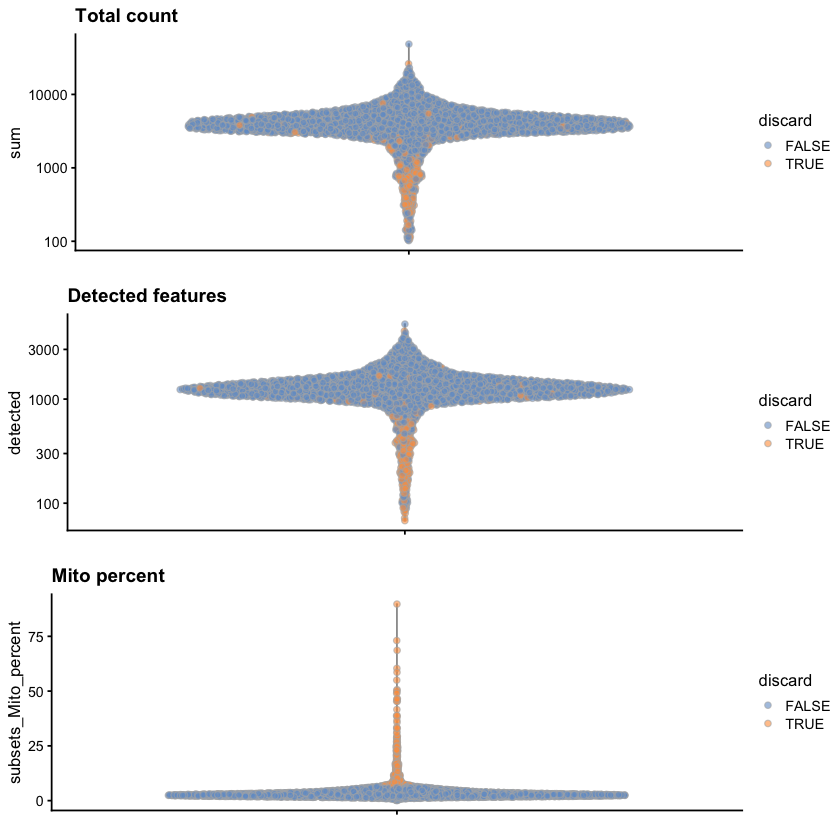

In [9]:
gridExtra::grid.arrange(
    plotColData(unfiltered, y="sum", colour_by="discard") +
        scale_y_log10() + ggtitle("Total count"),
    plotColData(unfiltered, y="detected", colour_by="discard") +
        scale_y_log10() + ggtitle("Detected features"),
    plotColData(unfiltered, y="subsets_Mito_percent",
        colour_by="discard") + ggtitle("Mito percent"),
    ncol=1
)

**Figure 1:** Plots depicting the distribution of various QC metrics within the PBMC dataset. Each point is a cell that is color coded according to whether it was discarded by the mitochondrial filter. Note that cells with high mitochondrial percents have been ~completely removed and most cells with low counts and numbers of detected features have been removed, suggesting that we have allowed cells with naturally low expression profiles to still be included in the data

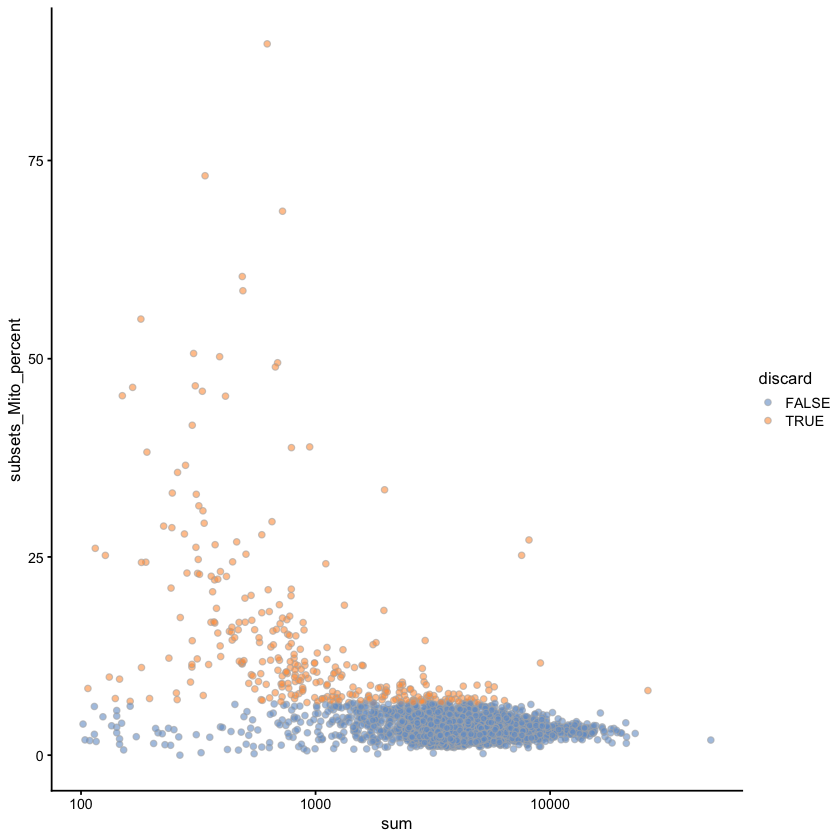

In [10]:
plotColData(unfiltered, x="sum", y="subsets_Mito_percent",
    colour_by="discard") + scale_x_log10()

**Figure 2:** Total reads vs percentage of mitochondrial reads in the PBMC dataset.

# Normalization
It is common for there to be differences in sequencing coverage between libraries in single-cell RNA sequencing data, usually arising from unavoidable technical variation in cDNA capture or PCR amplification across cells. Normalization aims to account for this variability in order to help insure that any differences in expression are the result of biology and not technical bias. Normalization in single-cell data must account for the presence of low/zero counts. This is achieved by pooling together the counts of many cells, a process called **deconvolution**.

- the quickCluster( ) function pre-clusters similar cells for separate normalization based on their expression values.
- the computeSumFactors( ) function implements the deconvolution strategy (Lun et al., 2016) for scaling normalization of separate cell clusters.
- the logNormCounts( ) function log-transforms the normalized expression values.

In [11]:
set.seed(1000)
clusters <- quickCluster(sce.pbmc)
sce.pbmc <- computeSumFactors(sce.pbmc, cluster=clusters)
sce.pbmc <- logNormCounts(sce.pbmc)
summary(sizeFactors(sce.pbmc))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.009379  0.710064  0.870865  1.000000  1.094423 13.947519 

The output of these functions is a new column in the SingleCellExperiment containing log-transformed, normalized expression values for each cell in our recently cleaned PBMC dataset.

*Library size normalization* is the simplest strategy for performing scaling normalization. We define the *library size* as the total sum of counts across all genes for each cell, the expected value of which is assumed to scale with any cell-specific biases. The *library size factor* for each cell is then directly proportional to its library size where the proportionality constant is defined such that the mean size factor across all cells is equal to 1.

On the other hand, the *deconvolution size factor* is the result of quick cellular clustering and normalization of these cellular clusters, which attempts to account for the dominance of low expression counts which can skew simpler normalizations. We see below that the deconvolution size factors exhibit cell type-specific deviations from the library size factors. This is consistent with the presence of composition biases that are introduced by strong differential expression between cell types. 

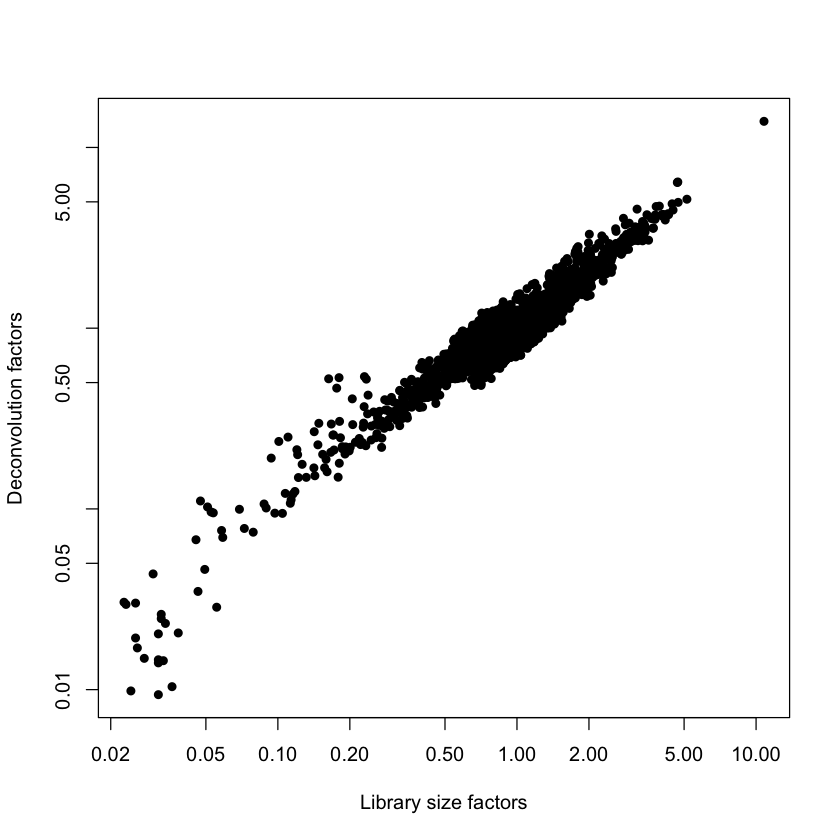

In [12]:
plot(librarySizeFactors(sce.pbmc), sizeFactors(sce.pbmc), pch=16,
    xlab="Library size factors", ylab="Deconvolution factors", log="xy")

**Figure 3:** Library size factors vs. deconvolution factors in the PBMC dataset.

# Feature selection
Feature selection is the process by which the complexity of a dataset is reduced by compressing differences in gene expression into a single dissimilarity metric between cells. This is most commonly done by selecting the genes which are most variable within the dataset. Basing downstream analyses like clustering and dimensionality reduction on these genes allows one to maximize useful information about the biology of the system while removing genes that contain random noise.

- There are many ways to do this, but it is best to use the modelGeneVarByPoisson( ) function to quantify technical noise for data with Unique Molecular Identifiers (UMIs). This function models the variance of log-expression values of the genes in the dataset and decomposes it into technical and biologica noise.
- The getTopHVGs( ) function simply takes selects the genes with the most variation. In this case, we have specified that to be the 10% most variable genes.

In [13]:
set.seed(1001)
# model variance of log-expression values for each cell and quantifies biological and technical noise 
dec.pbmc <- modelGeneVarByPoisson(sce.pbmc)
# retrieves top 10% most variable genes
top.pbmc <- getTopHVGs(dec.pbmc, prop=0.1)

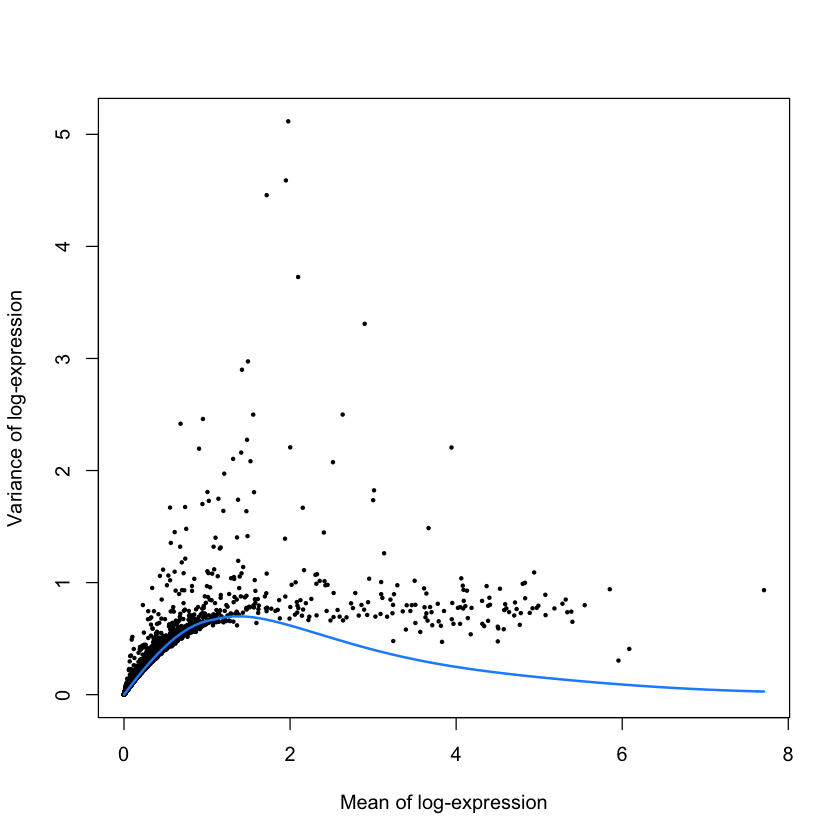

In [14]:
plot(dec.pbmc$mean, dec.pbmc$total, pch=16, cex=0.5,
    xlab="Mean of log-expression", ylab="Variance of log-expression")
curfit <- metadata(dec.pbmc)
curve(curfit$trend(x), col='dodgerblue', add=TRUE, lwd=2)

**Figure 4:** Gene variance as a function of the mean log-expression values in the PBMC dataset. Each point represents a gene (black) with the mean-variance trend (blue) fitted to simulated Poisson counts.

# Dimensionality Reduction
Dimensionality reduction compresses gene variation into a single dimension. This reduces computational work in downstream analyses like clustering, as calculations only need to be performed for a few dimensions rather than thousands of genes, reduces noise by averaging across multiple genes to obtain a more precise representation of the patterns in the data, and helps to make visually comprehensible representations of the data.

*Principal components analysis* (PCA) discovers axes in high-dimensional space that capture the largest amount of variation.

In [15]:
set.seed(10000)
sce.pbmc <- denoisePCA(sce.pbmc, subset.row=top.pbmc, technical=dec.pbmc)

set.seed(100000)
sce.pbmc <- runTSNE(sce.pbmc, dimred="PCA")

set.seed(1000000)
sce.pbmc <- runUMAP(sce.pbmc, dimred="PCA")

The *denoisePCA( )* function selects a threshold for the number of PCs based on some threshold T. In this case, this is done based off of both the most variable genes. This function typically retains more PCs than other methods, sacrificing increased noise for a more PCs to capture biologically relevant signal.

*t-stochastic neighbor embedding* t-SNE is the industry standard for visualizing scRNA-seq data. This method finds a low-dimensional representation that preserves some distance between each cell and it's neighbors.

The uniform manifold approximation and projection (UMAP) method is a popular alternative to t-SNE for non-linear dimensionality reduction. UMAP visualizations tend to contain more compact and spaced out clusters and the process is less computationally intensive than t-SNE.

# Clustering
Clustering is the route by which cells in scRNA-seq data are empirically grouped based on similar expression profiles, which allows for the data to be summarized in ways which are more interpretable by humans. After annotating clusters based on marker-genes, clusters can be more readily viewed as biological units such as cell types or states. It is useful to note that clustering is an empirical approach to discovering often murky biological meaning (cell types/states). Some people might be satisfied by discovering the major cell types. Others might desire subtypes. As such, it is important to note that clustering is only another method for exploring the potential biological meaning of scRNA-seq data.

*Graph-based clustering* is a flexible and scalable technique for clustering large scRNA-seq datasets. This method builds a graph where each node is a cell connected to it's nearest neighbors in space and each edge is weighted according to the similarity between the expression profiles of cells. When using the *buildSNNGraph( )* function, the parameter *k* is the most relevant parameter, which defines the number of nearest-neighbors that will be used to construct the graph.

In [16]:
# build nearest-neighbor graph
g <- buildSNNGraph(sce.pbmc, k=10, use.dimred = 'PCA')
# identify clusters
clust <- igraph::cluster_walktrap(g)$membership
colLabels(sce.pbmc) <- factor(clust)

In [17]:
# tells us the number of cells in each cluster
table(colLabels(sce.pbmc))


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18 
585 518 364 458 170 791 295 107  45  46 152  84  40  60 142  16  28  21 

In [18]:
options(repr.plot.width=8, repr.plot.height=8)

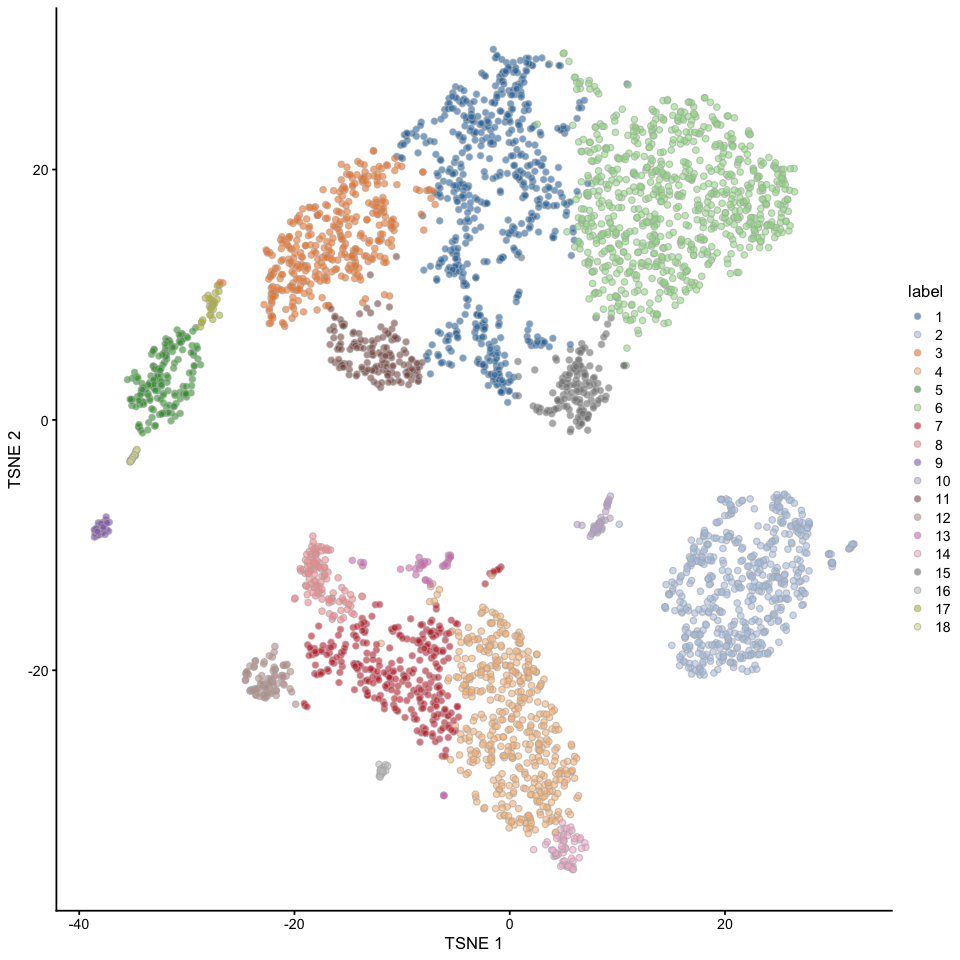

In [19]:
plotTSNE(sce.pbmc, colour_by="label")

**Figure 5:** t-SNE plot of the PBMC data. Each point is a cell and the cells are colored according to their clusters.

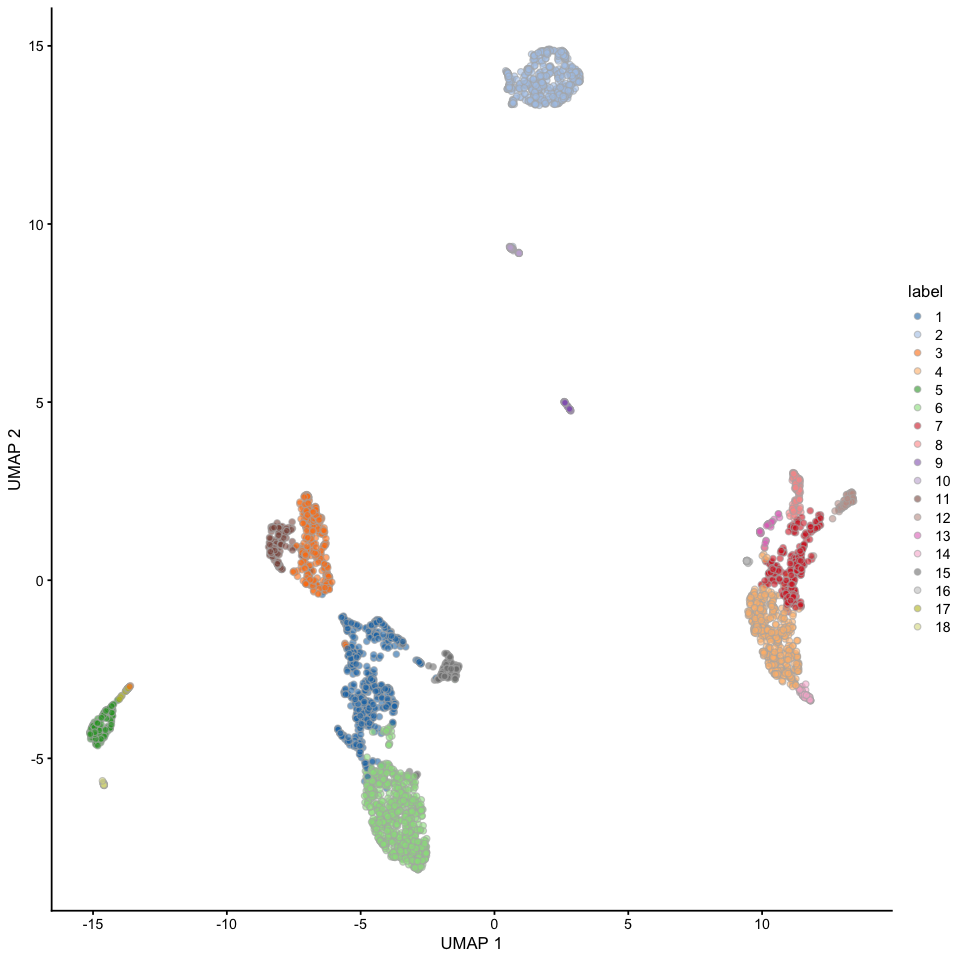

In [20]:
plotUMAP(sce.pbmc, colour_by="label")

**Figure 6:** UMAP plot of the PBMC data. Each point is a cell and the cells are colored according to their clusters. Note that despite differences in the location, spacing, and density of clusters, the same clusters tend to be more similar to each other than to other clusters in both visualizations.

# Marker Gene Identification
So that we can assign some sort of biological meaning to these clusters, it is necessary to identify the marker genes within these clusters that presumably drive separation between clusters. Assuming that these genes are functionally annotated, we can then treat these clusters and their associated marker genes as a proxy for cell type identity.

The basic principle of marker gene identification is the detection of differential expression (DE) between clusters. Different approaches can be used to statistically compute the most differentially expressed genes and to subsequently rank order these genes.

*Welch's t-test* is the standard statistical test for differential expression between cells, captured here within the *findMarkers( )* function. By specifying **up** in the direction parameter, we perform a one-sided t-test that only considers up-regulated genes. Furthermore, specifying pval.type="some" is a compromise made to rank genes based on their average p-values, effectively testing the hypothesis that at least 50% of the pair-wise comparisons between clusters exhibit no differential expression.

In [21]:
markers <- findMarkers(sce.pbmc, pval.type="some", direction="up")

We can now explore the top genes for each cluster and check their expression profiles across the dataset.

In [22]:
marker.set <- markers[["6"]]
as.data.frame(marker.set[1:5,1:3])

,p.value,FDR,summary.logFC
,<dbl>,<dbl>,<dbl>
LEF1,5.138028e-147,1.731207e-142,1.0244140
CCR7,7.540177e-122,1.270294e-117,0.9482820
CD3G,1.859222e-119,2.088154e-115,0.9547439
MAL,2.156003e-77,1.816109e-73,0.5861319
RPL32,2.234474e-63,1.505767e-59,1.7798441


- *LEF1* encodes for a protein that is expressed in pre-B and T-cells. High expression of this gene has been associated with lymphocytic leukemia and colorectal cancer.

- *CCR7* encodes for a protein that is expressed in various lymphoid tissues and activates B and T-cells.

- *CD3G* is part of a protein (CD3) that associates with T-cell surfaces.

- *MAL* encodes for a protein that is typically found in the endoplasmic reticulum of T-cells.

- *RPL32* encodes for a ribosomal protein that is part of the 60S subunit.

Overall, the top genes of cluster 6 seem to be mostly associated with T-cells.

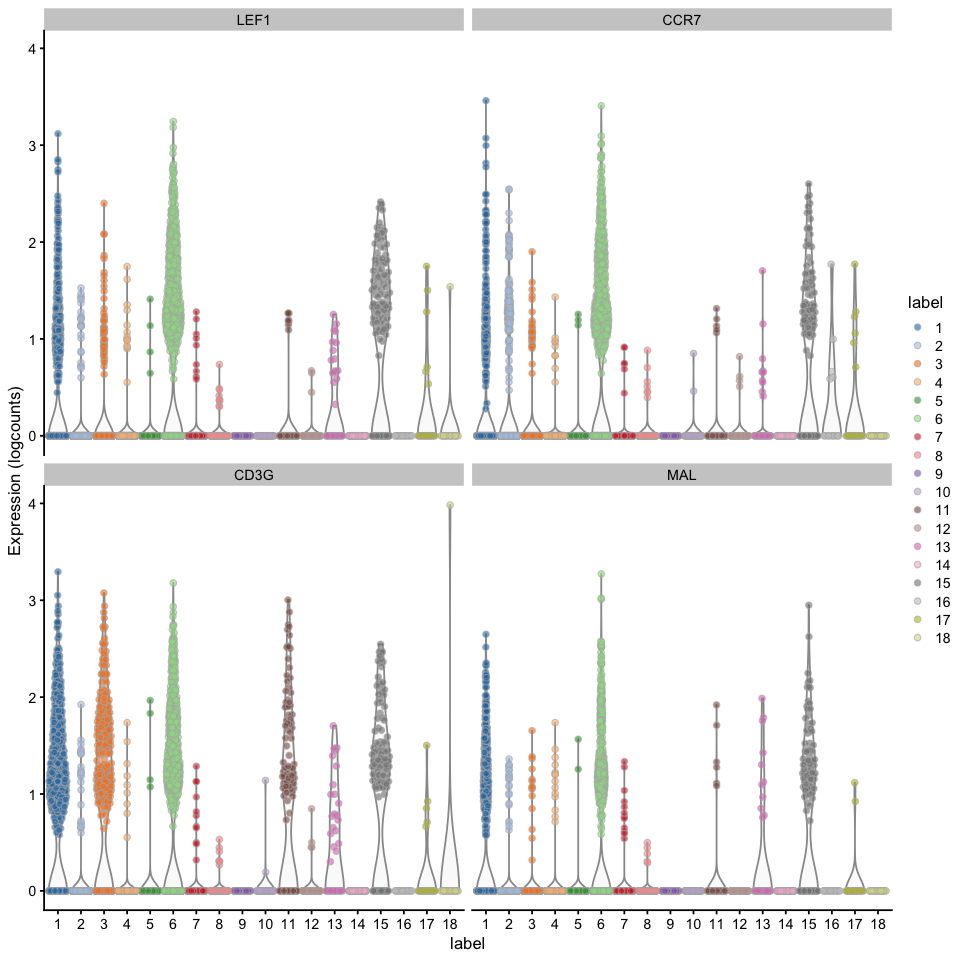

In [23]:
plotExpression(sce.pbmc, features=c("LEF1", "CCR7", "CD3G", "MAL"), x="label", colour_by="label")

**Figure 7:** Expression counts for the LEF1, CCR7, CD3G, and MAL genes. These genes are all associated with T-cell expression, structure, and function. These genes are highly expressed in clusters 1, 6, and 15, which aligns with our visualizations in Figures 5 and 6. 

We have reason to suspect that clusters 1, 6, and 15 might represent T-cells. Let's check!

# Cell Type Annotation
Determining the biological function of cell clusters can be a difficult task. The simplest way to computationally assign meaning to scRNA-seq datasets is by using reference datasets that have been manually annotated or by utilizing curated gene sets associated with certain biological functions from databases such as the Kyoto Encyclopedia of Genes and Genomes (KEGG).

The *SingleR* package contains reference transcriptomic datasets of pure cell types which can be used to perform cell type recognition.

In [24]:
# reference SingleCellExperiment
suppressMessages(ref <- BlueprintEncodeData())
# assign likely cell types to our PBMC datasets
suppressMessages(pred <- SingleR(test=sce.pbmc, ref=ref, labels=ref$label.main))
table(pred$labels)


     B-cells CD4+ T-cells CD8+ T-cells           DC  Eosinophils Erythrocytes 
         525          755         1254            1            1            5 
         HSC    Monocytes     NK cells 
          14         1116          251 

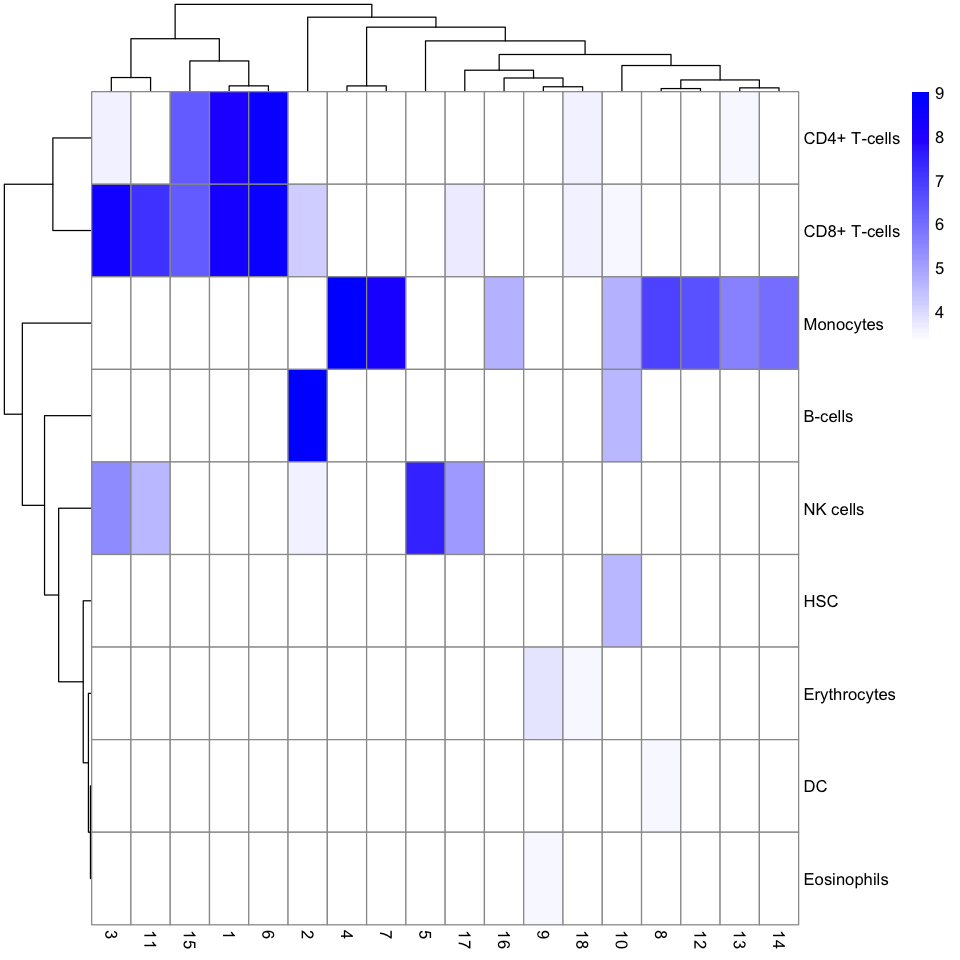

In [25]:
tab <- table(Assigned=pred$pruned.labels, Cluster=colLabels(sce.pbmc))

pheatmap(log2(tab+10), color=colorRampPalette(c("white", "blue"))(101))

**Figure 7:** Heatmap showing cell type assignments for the previously identified clusters based on the reference datasets in the SingleR package. Many of the clusters are most correlated with monocytes, T-cells, and NK cells.

Interestingly, we find that clusters 1, 6, and 15 are indeed associated with T-cells as our previous marker gene exploration suggested! Moreover, we also can see that the majority of the cells in our dataset are most closely associated with T-cells, monocytes, B-cells, and NK cells. 

# References

Zheng, G. X., J. M. Terry, P. Belgrader, P. Ryvkin, Z. W. Bent, R. Wilson, S. B. Ziraldo, et al. 2017. “Massively parallel digital transcriptional profiling of single cells.” Nat Commun 8 (January): 14049.